In [1]:
import sys
sys.path.append('..')
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import Utils.dataframe as dataframe_helper
import Utils.learning as learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [3]:
experiment_name = "Unigram Model"

## Feature Engineering

In [4]:
def feature_engineering_one_hot(df:pd.DataFrame, N:int = None) -> pd.DataFrame:
    with open("../Data/top_word/top_fake_word.txt", "r") as f:
        fake_words = dataframe_helper.string_to_list(f.read())
  
    with open("../Data/top_word/top_genuine_word.txt", "r") as f:
        non_fake_words = dataframe_helper.string_to_list(f.read())

    fake_words = fake_words[:N]
    non_fake_words = non_fake_words[:N]
        
    # KL one hot encoding
    fakeWordOneHot = []
    nonFakeWordOneHot = []

    for content in df['reviewContent']:
        fakeOneHot = ''
        nonFakeOneHot = ''
        words = re.findall(r'\b[A-Za-z][a-z]{2,9}\b', content)

        for word in fake_words:
            if word in words:
                fakeOneHot += '1'
            else:
                fakeOneHot += '0'

        for word in non_fake_words:
            if word in words:
                nonFakeOneHot += '1'
            else:
                nonFakeOneHot += '0'
                
        fakeWordOneHot.append(fakeOneHot)
        nonFakeWordOneHot.append(nonFakeOneHot)
    
    result = pd.DataFrame()
    result['fakeWordsOneHot'] = fakeWordOneHot
    result['nonFakeWordsOneHot'] = nonFakeWordOneHot

    result = dataframe_helper.onehot(result, 'fakeWordsOneHot', fake_words, 'fake')
    result = dataframe_helper.onehot(result, 'nonFakeWordsOneHot', non_fake_words, 'non fake')
    
    result['reviewContent'] = df['reviewContent']
    result['flagged'] = df['flagged']

    return result
    

In [5]:
def feature_engineering_word_count(df:pd.DataFrame, N:int = None) -> pd.DataFrame:
    with open("../Data/top_word/top_fake_word.txt", "r") as f:
        fake_words = dataframe_helper.string_to_list(f.read())
  
    with open("../Data/top_word/top_genuine_word.txt", "r") as f:
        non_fake_words = dataframe_helper.string_to_list(f.read())

    fake_words = fake_words[:N]
    non_fake_words = non_fake_words[:N]
        
    # KL word count
    fakeWordsCount = []
    nonFakeWordsCount = []

    for content in df['reviewContent']:
        words = re.findall(r'\b[A-Za-z][a-z]{2,9}\b', content)
        fakeCount = 0
        nonFakeCount = 0
        for word in words:
            if word in fake_words:
                fakeCount += 1
            elif word in non_fake_words:
                nonFakeCount += 1
        fakeWordsCount.append(fakeCount)
        nonFakeWordsCount.append(nonFakeCount)

    result = pd.DataFrame()
    result['fakeWordsCount'] = fakeWordsCount
    result['nonFakeWordsCount'] = nonFakeWordsCount
    result['reviewContent'] = df['reviewContent']
    result['flagged'] = df['flagged']
    
    return result
    

In [6]:
def feature_engineering_cVect(df:pd.DataFrame, N:int = None) -> pd.DataFrame:
    result = pd.DataFrame()
    result['reviewContent'] = df['reviewContent']
    result['flagged'] = df['flagged']
    return result
    

## Make train dataset

In [7]:
df = dataframe_helper.load_data()
df = dataframe_helper.data_cleaning(df)
df = feature_engineering_cVect(df)
# df = feature_engineering_one_hot(df)
# df = feature_engineering_word_count(df)

In [8]:
df

,reviewContent,flagged
0,unlike next we d eaten previous night dish com...,N
1,probably one best meals i ve ever it s perform...,N
2,service impeccable experience presentation coo...,N
3,the problem places like this given exhorbitant...,N
4,i idea write review dining alinea brings whole...,N
...,...,...
26953,it s taco bell higher prices taco bell what st...,N
26954,yellow rose favorite mine i d go every day i c...,N
26955,not bad we ate odd wicker seats inviting we at...,N
26956,we surprised eagerly roped pop trivia game upo...,N


In [9]:
df['flagged'].value_counts()

N    20752
Y     6206
Name: flagged, dtype: int64

In [10]:
over_sampled_df = dataframe_helper.over_sampling(df=df, target='flagged', big_sample='Y', small_sample='N')

Over-Sampling Data
Over-Sampling Complete


In [11]:
over_sampled_df['flagged'].value_counts()

N    20752
Y    20752
Name: flagged, dtype: int64

In [10]:
X = over_sampled_df.loc[:, 'reviewContent']
y = over_sampled_df.loc[:, 'flagged']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=11)

In [12]:
cVect = CountVectorizer()
cVect.fit(X_train)

CountVectorizer()

In [13]:
# document term vector (dtv)
dtv = cVect.transform(X_train)
dtv = dtv.toarray()

In [14]:
# lr = LogisticRegression(verbose=1)

# grid={"C":[float(i) for i in range(1, 3)], "penalty":["l2"], "solver":[ 'lbfgs', 'liblinear']}
# logreg_cv=GridSearchCV(lr, grid, cv=4)
# logreg_cv.fit(dtv,y_train)

# print("Tuned Hpyerparameters :",logreg_cv.best_params_)
# print("accuracy :",logreg_cv.best_score_)

In [15]:
lr = LogisticRegression(solver='liblinear', penalty ='l2' , C = 2.0)
lr.fit(dtv, y_train)

LogisticRegression(C=2.0, solver='liblinear')

In [16]:
test_dtv = cVect.transform(X_test)
test_dtv = test_dtv.toarray()
print(f"Number of Observations: {test_dtv.shape[0]}\nTokens/Features: {test_dtv.shape[1]}")

Number of Observations: 8301
Tokens/Features: 36777


In [17]:
pred = lr.predict(test_dtv)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           N       0.92      0.73      0.82      4202
           Y       0.77      0.94      0.85      4099

    accuracy                           0.83      8301
   macro avg       0.85      0.83      0.83      8301
weighted avg       0.85      0.83      0.83      8301



In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english')) 

In [27]:
def predict_class(lr):
    text = input('Enter Text: ')
    text = [' '.join([ word for word in word_tokenize(text)  if not word in stop_words])]
    t_dtv = cVect.transform(text).toarray()
    print('Predicted Class:', end = ' ')
    print(lr.predict(t_dtv)[0]) 
    prob = lr.predict_proba(t_dtv)*100
    print(f"Not Fake: {prob[0][0]}%\nFake: {prob[0][1]}%")
    plt.figure(figsize=(12, 6))
    sns.barplot(x =['Not Fake', 'Fake'] , y = [prob[0][0], prob[0][1]])
    plt.xlabel('Class')
    plt.ylabel('Probalility')
    plt.show()

Predicted Class: Y
Not Fake: 37.1593016198055%
Fake: 62.8406983801945%


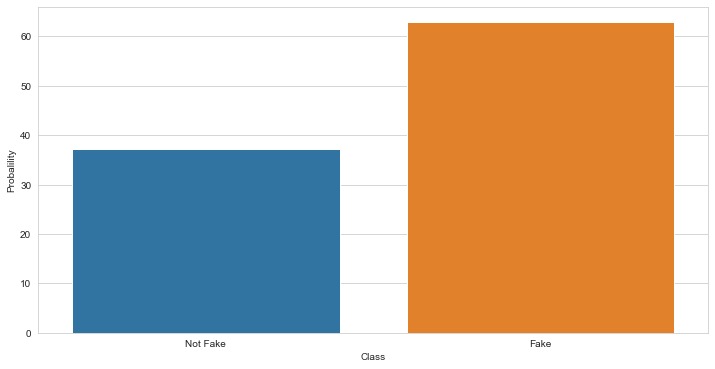

In [28]:
predict_class(lr)

In [29]:
import joblib
joblib.dump(lr, "fake_nonFake_lr.joblib") 
joblib.dump(cVect, "fake_nonFake_cVect.joblib")

['fake_nonFake_cVect.joblib']